In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sturdr.channel.gps_l1ca_channel import gps_l1ca_code

TWO_PI = 2 * np.pi

# signal parameters
CODE_LEN = 1023                             # chips
CODE_FREQ = 1.023e6                         # chips/s
CARRIER_FREQ = 1.57542e9                    # Hz
KAPPA = CODE_FREQ / CARRIER_FREQ
SAMP_FREQ = 20e6                             # samples/s
IF_FREQ = TWO_PI * 5e6                    # rad/s
T_S = 1 / SAMP_FREQ                         # s

# test parameters
init_carrier_doppler = 1800.0                    # Hz
init_code_doppler = KAPPA * init_carrier_doppler # chips/s
init_code_phase = 100.0                          # chips
init_carrier_phase = 0.0                         # rad

# simulate 1 seconds of signal
total_time = int(1 * 10)              # ms
samples_per_ms = int(SAMP_FREQ / 1000)  # samples/ms
total_len = total_time * samples_per_ms # samples
gps_code = gps_l1ca_code(1)

signal = np.zeros(total_len, dtype=np.complex128)
carrier_phase = np.zeros(total_len, dtype=np.double)
code_phase = np.zeros(total_len, dtype=np.double)
carrier_doppler = np.zeros(total_len, dtype=np.double)
code_doppler = np.zeros(total_len, dtype=np.double)
for k in range(total_len):
    t_k = k * T_S
    if k == 0:
        carrier_phase[k] = init_carrier_phase
        code_phase[k] = init_code_phase
    else:
        carrier_doppler[k] = init_carrier_doppler + 10*t_k
        code_doppler[k] = KAPPA * carrier_doppler[k]
        carrier_phase[k] = carrier_phase[k-1] + (IF_FREQ + TWO_PI*carrier_doppler[k]) * T_S
        code_phase[k] = code_phase[k-1] + (CODE_FREQ + code_doppler[k]) * T_S
    signal[k] = np.exp(1j * carrier_phase[k]) * gps_code[int(np.mod(code_phase[k], 1023))]


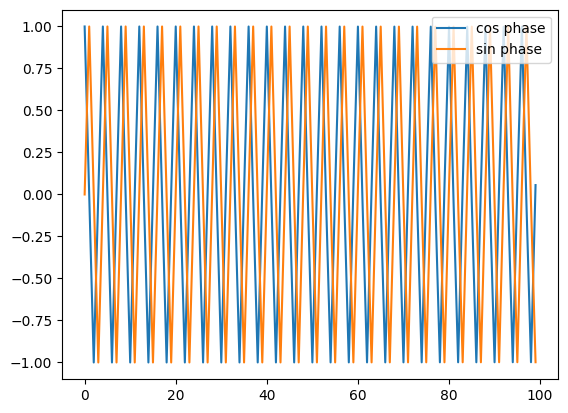

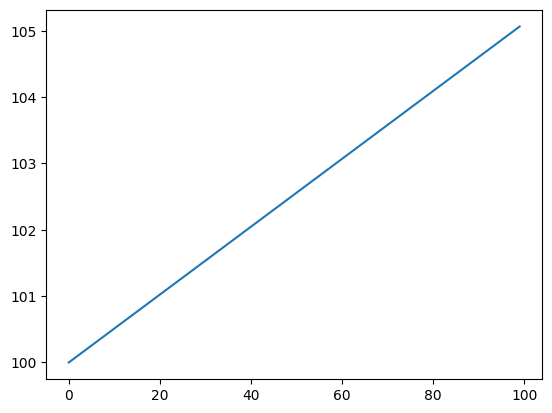

In [2]:
plt.figure()
plt.plot(np.cos(carrier_phase[:100]), label='cos phase')
plt.plot(np.sin(carrier_phase[:100]), label='sin phase')
plt.legend()
plt.figure()
plt.plot(code_phase[:100], label='code phase')
plt.show()

In [3]:
from sturdr.dsp.acquisition import PcpsSearch, Peak2NoiseFloorComparison

# acquire the signal
correlation_map = PcpsSearch(
    rfdata=signal[:samples_per_ms],
    code=gps_code,
    doppler_range=5000,
    doppler_step=200,
    sampling_freq=SAMP_FREQ,
    code_freq=CODE_FREQ,
    intermediate_freq=IF_FREQ / TWO_PI,
    coherent_integration=1,
    non_coherent_integration=1
)

# test for succesfull acquisition
first_peak_idx, acquisition_metric = Peak2NoiseFloorComparison(correlation_map)

success = False
acq_doppler = np.nan
acq_code_phase = np.nan
if acquisition_metric > 50.0:
    success = True
    acq_doppler = float(-5000 + first_peak_idx[0] * 200)
    acq_code_phase = first_peak_idx[1]
    
print(f"Success = {success}, {acquisition_metric}")
print(f"Acquired Doppler = {acq_doppler}")
print(f"Acquired Code Phase = {acq_code_phase * CODE_FREQ / SAMP_FREQ} chips, {acq_code_phase} samples")
print(f"True Doppler = {carrier_doppler[0]}")
print(f"True Code Phase = {code_phase[samples_per_ms]}")

# # Display Results
# x = np.arange(-5000, 5000+1, 200)
# y = np.linspace(0,1023,samples_per_ms)
# x,y = np.meshgrid(x,y)
# plt.figure()
# ax = plt.axes(projection='3d')
# ax.set_xlabel("Doppler [Hz]")
# ax.set_ylabel("Code [Chips]")
# ax.plot_surface(x, y, correlation_map.T, 
#                 rstride=1, cstride=5, 
#                 cmap=plt.get_cmap('turbo'))
# plt.show()

Success = True, 195.04475034595092
Acquired Doppler = 1800.0
Acquired Code Phase = 923.00175 chips, 18045 samples
True Doppler = 0.0
True Code Phase = 1123.0011688345196


In [4]:
from sturdr.dsp.tracking import TrackingKF, NaturalFrequency, FLLassistedPLL_3rdOrder, PLL_2ndOrder
from sturdr.dsp.discriminator import PllCostas, FllAtan2, DllNneml2
from sturdr.dsp.gnss_signal import AccumulateEPL

w0p = NaturalFrequency(0.01,3)   # natural radian frequency for 3rd order PLL
w0f = NaturalFrequency(0.001,2)   # natural radian frequency for 2nd order FLL
w0d = NaturalFrequency(0.001,2)   # natural radian frequency for 2nd order DLL
# w0p = NaturalFrequency(6.0,3)   # natural radian frequency for 3rd order PLL
# w0f = NaturalFrequency(0.5,2)   # natural radian frequency for 2nd order FLL
# w0d = NaturalFrequency(0.5,2)   # natural radian frequency for 2nd order DLL
kf = TrackingKF(w0p, w0f, w0d, 
                doppler=TWO_PI*acq_doppler,
                nominal_carrier_freq=TWO_PI*CARRIER_FREQ, 
                nominal_code_freq=CODE_FREQ,
                intermediate_freq=IF_FREQ, 
                cn0=100000,
                T=0.001)

IP = np.zeros(total_time - 1)
QP = np.zeros(total_time - 1)
sample_count = np.zeros(total_time, dtype=int)
track_doppler    = np.zeros(total_time)
track_code_phase = np.zeros(total_time)
track_code_doppler = np.zeros(total_time)
sample_count[0] = acq_code_phase
track_doppler[0] = acq_doppler
track_code_phase[0] = acq_code_phase * CODE_FREQ / SAMP_FREQ
track_code_doppler[0] = KAPPA * acq_doppler

rem_carrier_phase = 0.0
doppler_est = TWO_PI * acq_doppler
jitter_est = 0.0
doppler_accumulator = doppler_est
jitter_accumulator = 0.0
rem_code_phase = 0.0
code_doppler_est = KAPPA * acq_doppler
chip_accumulator = code_doppler_est
for k in range(total_time - 1): 
    # --- dump --- 
    code_phase_step = (CODE_FREQ + code_doppler_est) / SAMP_FREQ
    total_samples = np.ceil((CODE_LEN - rem_code_phase) / code_phase_step).astype(np.uint32)
    sample_count[k+1] = sample_count[k] + total_samples
       
    # --- integrate ---
    E, P, L, P1, P2, _, rem_carrier_phase, rem_code_phase \
     = AccumulateEPL(
        rfdata=signal[sample_count[k] : sample_count[k+1]],
        code=gps_code,
        tap_spacing=0.25,
        code_len=CODE_LEN,
        code_freq=(CODE_FREQ + code_doppler_est),
        sampling_freq=SAMP_FREQ,
        carrier_freq=(IF_FREQ + doppler_est),
        carrier_jitter=jitter_est,
        rem_code_phase=rem_code_phase,
        rem_carrier_phase=rem_carrier_phase,
        n_samples=total_samples,
        samples_accumulated=0,
        half_samples=int(total_samples/2),
    )
    
    # --- discriminator ---
    t = total_samples / SAMP_FREQ
    phase_err = PllCostas(P.real, P.imag)                         # [rad]
    freq_err = FllAtan2(P1.real, P2.real, P1.imag, P2.imag, t/2) # [rad/s]
    chip_err = DllNneml2(E.real, E.imag, L.real, L.imag)         # [chip]
    
    # --- kalman filter ---
    kf.UpdateIntegrationTime(t)
    x = kf.Run(phase_err, freq_err, chip_err)
    rem_carrier_phase = np.mod(x[0], TWO_PI)
    doppler_est = x[1]
    jitter_est = x[2]
    rem_code_phase = x[3] - CODE_LEN
    code_doppler_est = x[4] + KAPPA * (x[1] + t * x[2]) / TWO_PI
    kf.x[0] = rem_carrier_phase
    kf.x[3] = rem_code_phase
    # doppler_est, jitter_accumulator, doppler_accumulator = FLLassistedPLL_3rdOrder(
    #     phase_err, freq_err, jitter_accumulator, doppler_accumulator, t, w0p, w0f
    # )
    # code_doppler_est, chip_accumulator = PLL_2ndOrder(chip_err, chip_accumulator, t, w0d)
    # code_doppler_est += KAPPA * doppler_est / TWO_PI
    # rem_code_phase -= CODE_LEN
    
    # save outputs
    IP[k] = P.real
    QP[k] = P.imag
    track_doppler[k+1] = doppler_est / TWO_PI
    track_code_phase[k+1] = track_code_phase[k] + (CODE_FREQ+code_doppler_est) / SAMP_FREQ * total_samples
    track_code_doppler[k+1] = code_doppler_est

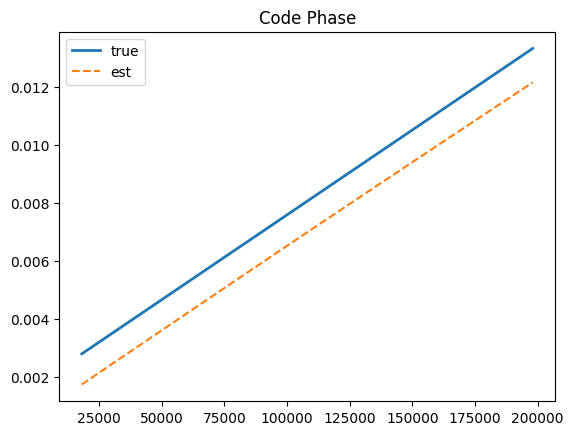

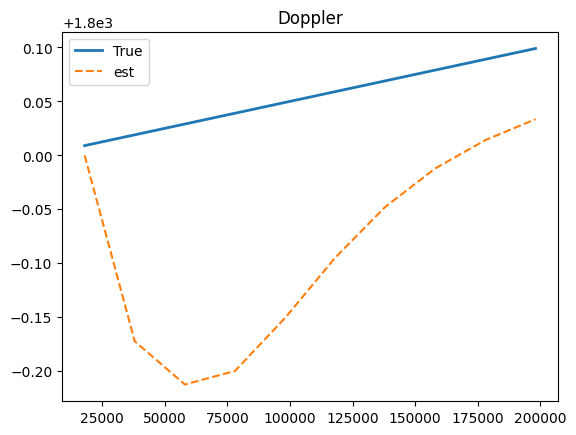

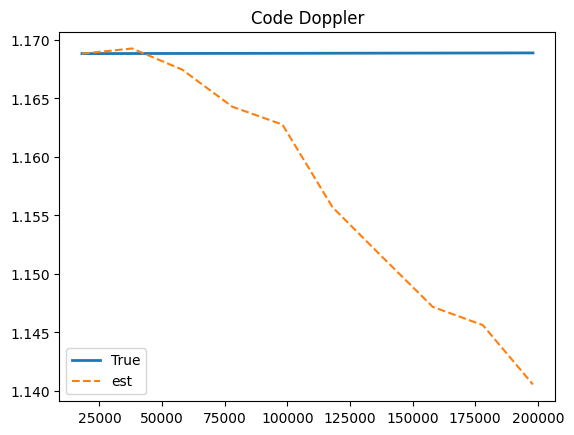

0.0 1800.0999995
1800.0 1800.0335120696413


In [5]:
plt.figure()
plt.plot(sample_count, np.mod(code_phase[sample_count],1023), label='true', linewidth=2)
plt.plot(sample_count, np.mod(track_code_phase,1023)+init_code_phase-1023, '--', label='est')
plt.legend()
plt.title('Code Phase')

plt.figure()
plt.plot(sample_count, carrier_doppler[sample_count], label=True, linewidth=2)
plt.plot(sample_count, track_doppler, '--', label='est')
plt.legend()
plt.title('Doppler')

plt.figure()
plt.plot(sample_count, code_doppler[sample_count], label=True, linewidth=2)
plt.plot(sample_count, track_code_doppler, '--', label='est')
plt.legend()
plt.title('Code Doppler')

plt.show()

print(carrier_doppler[0], carrier_doppler[-1])
print(track_doppler[0], track_doppler[-1])
# print(code_doppler[0], code_doppler[-1])
# print(code_doppler[0] / track_code_doppler[0])